<a href="https://colab.research.google.com/github/JanRibasGarriga/WhoIsWho/blob/main/MonocultureApproach_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **WhoIsWho - [MONOCULTURE / TRAINING]**
---





<font size = 4>This notebook is largely based on the paper: 

> <font size = 4> Stringer, Carsen, Tim Wang, Michalis Michaelos, and Marius Pachitariu. 2021. **“Cellpose: A Generalist Algorithm for Cellular Segmentation.”** Nature Methods 18 (1): 100–106. https://doi.org/10.1038/s41592-020-01018-x.

> <font size = 4> The Original code is freely available in GitHub: https://github.com/MouseLand/cellpose

<font size = 4> and on the information extracted from: 

> <font size = 4>**Transfer learning and fine-tuning**, 2017 François Chollet. https://www.tensorflow.org/tutorials/images/transfer_learning    

<font size = 4>Please also cite the original source when using or developing this notebook.

In [ ]:
#@markdown ##Double click to see the license information

#------ License for Cellpose [5. Segmentation Block] ------
# MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.



---


<font size = 4> Before you run the notebook, please ensure that logged into your Google account and have the training dataset to be processed stored on the respective Google Drive. 

<font size = 4> The data must be stored with the following structure:


*   Data/
  *   TL/
      * image_1.tif 
      * image_2.tif 
      * image_3.tif
      * ...
  
  *   DAPI/
      * image_1.tif 
      * image_2.tif 
      * image_3.tif
      * ...

# **1. Initialise the Colab session**

---



In [1]:
#@markdown ##Run this cell to check if you have GPU access

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  gpu_available = False
  print("You are not connected to a GPU.") 
  print("Please, check the selected runtime type.") 
  print("Expect slow performance, especially if classification training needs to be performed.")

else:
  gpu_available = True
  print("GPU device available")

if gpu_available:
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print("To enable a GPU accelerator, check the selected runtime type.")
  else:
    print(gpu_info)

  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print("Your runtime has {:.1f} gigabytes of available RAM\n".format(ram_gb))
  if ram_gb < 20:
    print("To enable a high-RAM runtime, check the selected runtime type.")
  else:
    print('You are using a high-RAM runtime!')

GPU device available
Thu Apr 29 14:41:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    349MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                   

In [2]:
#@markdown ##Run this cell to mount your Google Drive in your virtual machine of this exectuable Colab document.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Paste the authorization code. 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **2. Install dependencies**

---

In [ ]:
#@markdown ##Install general dependencies

import os
import shutil
from PIL import Image
import skimage
from skimage.util.shape import view_as_windows
from skimage import io
from skimage import util
from skimage import filters
from skimage import img_as_ubyte, img_as_uint
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@markdown ##Install Cellpose  dependencies

!pip install tifffile
from tifffile import imread, imsave
from zipfile import ZIP_DEFLATED

!pip install cellpose 
from cellpose import models
from cellpose import plot 


     |████████████████████████████████| 13.2MB 5.5MB/s 
     |████████████████████████████████| 37.6MB 121kB/s 
  Created wheel for cellpose: filename=cellpose-0.6.1-cp37-none-any.whl size=146565 sha256=a3e49b4c2d94616fc151bf2a52d2ea22ed660a7d88984b18d8de25e8f4ef510b
  Stored in directory: /root/.cache/pip/wheels/b8/75/c4/5496982964c6db2cfce60e5081a4a2f7f0ec9f0e381a73ae59
Successfully built cellpose


Downloading: "https://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
100%|██████████| 25.2M/25.2M [00:00<00:00, 59.8MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:00<00:00, 52.2MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:00<00:00, 56.6MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:00<00:00, 38.4MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 8.35MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_0" to /root/.cellpose/models/cytotorch_0
100%|██████████| 25.3M/25.3M [00:00<00:00, 52.2MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_1" to /root/.cellpose/models/cytotorch_1
100%|██████████| 25.3M/25.3M [00:00

In [ ]:
#@markdown ##Install bounding box dependencies

from skimage import morphology
from skimage import measure
import pandas as pd 

from PIL import Image
import skimage
from skimage import img_as_bool, img_as_ubyte
import numpy as np
from skimage import segmentation

In [ ]:
#@markdown ##Install classification block dependencies

import tensorflow
from tensorflow import keras

from keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from keras.layers.experimental import preprocessing
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Nadam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# **4. Data preparation**

---






## **4.1. Define path of the raw data**
---

In [ ]:
#@markdown ##Please specify the path to where the data is located in your Google Drive.

data_folder_path = '/content/gdrive/MyDrive/_WhoIsWhoData/TL8bits/Monoculture_10x_LowC/DatasetA' #@param {type:"string"}
data_folder_path = data_folder_path + "/"

if os.path.isdir(data_folder_path):
  tl_folder_path = os.path.join(data_folder_path, "TL/")
  dapi_folder_path = os.path.join(data_folder_path, "DAPI/")

else:
  print(R+'!! WARNING: The path selected does not exist !!'+W)

In [ ]:
#@title
#shutil.rmtree("/content/WhoIsWho")

In [ ]:
#@markdown ##Run this cell to create the directory structure in /content 

whoiswho_folder_path = "/content/WhoIsWho"
#shutil.rmtree(whoiswho_folder_path)

if not os.path.isdir(whoiswho_folder_path):

  # Define cell lines to be analyzed
  cell_lines_list = []
  for folder in sorted(os.listdir(data_folder_path)):
    for cell_line_name in sorted(os.listdir(os.path.join(data_folder_path, folder))):
      cell_lines_list.append(cell_line_name)
    break

  os.mkdir(whoiswho_folder_path)

  # Defining PATCHES paths and creating folders and subfolders
  patches_folder_path = os.path.join(whoiswho_folder_path, "Patches")
  os.mkdir(patches_folder_path)

  tlpatches_folder_path = os.path.join(patches_folder_path, "TL/")
  os.mkdir(tlpatches_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(tlpatches_folder_path, str(cell_line_name)))

  dapipatches_folder_path = os.path.join(patches_folder_path, "DAPI/")
  os.mkdir(dapipatches_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(dapipatches_folder_path, str(cell_line_name)))

  cellposelabelpatches_folder_path = os.path.join(patches_folder_path, "CellposeLabel/")
  os.mkdir(cellposelabelpatches_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(cellposelabelpatches_folder_path, str(cell_line_name)))
  
  regionpropsdf_folder_path = os.path.join(patches_folder_path, "Regionpropsdf/")
  os.mkdir(regionpropsdf_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(regionpropsdf_folder_path, str(cell_line_name)))

  # Defining SNIPPETS paths and creating folders and subfolders
  snippets_folder_path = os.path.join(whoiswho_folder_path, "Snippets")
  os.mkdir(snippets_folder_path)

  tlsnippets_folder_path = os.path.join(snippets_folder_path, "TL/")
  os.mkdir(tlsnippets_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(tlsnippets_folder_path, str(cell_line_name)))

  # Defining FIGURES paths and creating folders and subfolders
  figures_folder_path = os.path.join(whoiswho_folder_path, "Figures")
  os.mkdir(figures_folder_path)

  generalfigures_folder_path = os.path.join(figures_folder_path, "GeneralFigures")
  os.mkdir(generalfigures_folder_path)

  cellposefigures_folder_path = os.path.join(figures_folder_path, "CellposeFigures")
  os.mkdir(cellposefigures_folder_path)
  for cell_line_name in cell_lines_list:
    os.mkdir(os.path.join(cellposefigures_folder_path, str(cell_line_name)))

  # Defining MODEL paths and creating folders and subfolders
  model_folder_path = os.path.join(whoiswho_folder_path, "Model")
  os.mkdir(model_folder_path)

print("/content/WhoIsWho directory just created")
print("Files will be stored under this directory")
print("Remember to run the last section of the notebook to select and download the results to your computer")


/content/WhoIsWho directory just created
Files will be stored under this directory
Remember to run the last section of the notebook to select and download the results to your computer


A5--W00005--P00002.tif
A3--W00003--P00003.tif
A2--W00002--P00004.tif
A4--W00004--P00008.tif
A7--W00007--P00009.tif
A6--W00006--P00009.tif


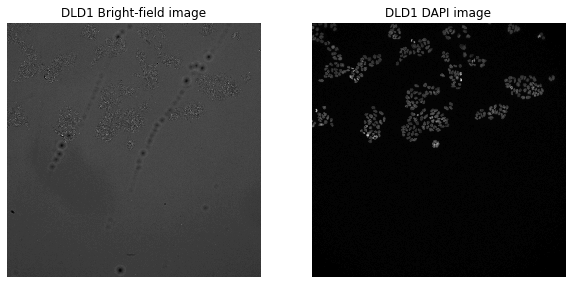

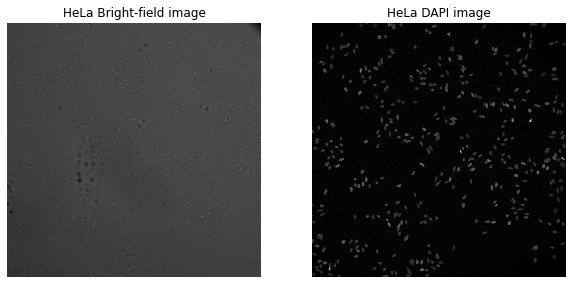

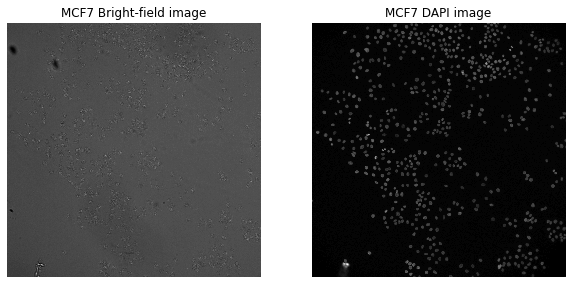

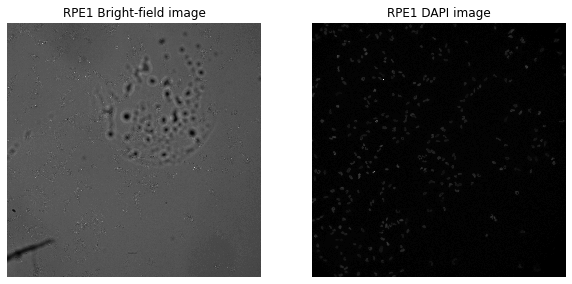

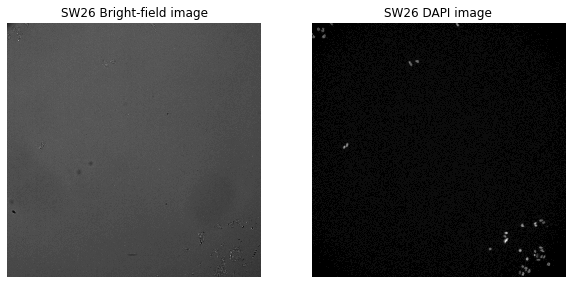

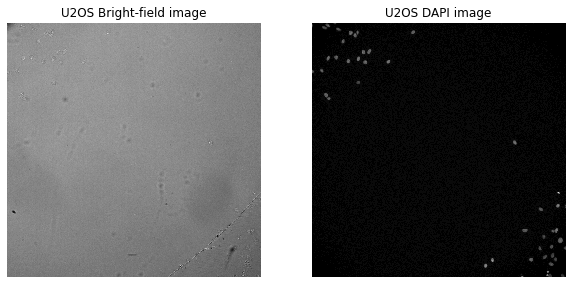

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to display and save an example of the images

##############################
######### FUNCTIONS ##########
##############################

base_name_image_list = []

for cell_line_name in cell_lines_list:
  tl_cellline_folder_path = os.path.join(tl_folder_path, cell_line_name)
  dapi_cellline_folder_path = os.path.join(dapi_folder_path, cell_line_name)

  for filename in os.listdir(tl_cellline_folder_path):
    random_choice = random.choice(os.listdir(tl_cellline_folder_path))

    tl_sample = io.imread(os.path.join(tl_cellline_folder_path, random_choice), as_gray = True)
    dapi_sample = io.imread(os.path.join(dapi_cellline_folder_path, random_choice), as_gray = True)

    print(random_choice)

    f = plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    plt.imshow(tl_sample, interpolation = 'nearest', cmap = 'gray')
    plt.title(f'{cell_line_name} Bright-field image')
    plt.axis('off');

    plt.subplot(1,2,2)
    plt.imshow(dapi_sample, interpolation = 'nearest', cmap = 'gray')
    plt.title(f'{cell_line_name} DAPI image')
    plt.axis('off');

    base_name_image = random_choice.replace(".tif", "")
    base_name_image_list.append(base_name_image)
    figure_name = (f"Image{cell_line_name}_{base_name_image}")

    plt.savefig(os.path.join(generalfigures_folder_path, figure_name + ".png"),
                dpi = 300, format = "png", bbox_inches = None)
    
    break

## **4.2. Creation of patches**

---



In [ ]:
def fittingPowerOfTwo(number):
  n = 0
  while 2**n <= number:
    n += 1 
  return 2**(n-1)

def estimatePatchSize(data_path, max_width = 512, max_height = 512):

  files = os.listdir(data_path)
  
  # Get the size of the first image found in the folder and initialise the variables to that
  n = 0 
  while os.path.isdir(os.path.join(data_path, files[n])):
    n += 1
  (height_min, width_min) = Image.open(os.path.join(data_path, files[n])).size

  # Screen the size of all dataset to find the minimum image size
  for file_ in files:
    if not os.path.isdir(os.path.join(data_path, file_)):
      (height, width) = Image.open(os.path.join(data_path, file_)).size
      if width < width_min:
        width_min = width
      if height < height_min:
        height_min = height
    break
  
  # Find the power of patches that will fit within the smallest dataset
  width_min, height_min = (fittingPowerOfTwo(width_min), fittingPowerOfTwo(height_min))

  # Clip values at maximum permissible values
  if width_min > max_width:
    width_min = max_width

  if height_min > max_height:
    height_min = max_height
  
  return (width_min, height_min)

#@markdown ##Run to define the dimensions of the patches. 

patch_width, patch_height = estimatePatchSize(
    os.path.join(tl_folder_path, cell_lines_list[0]
))

print(f"Patch dimensions (patch_width, patch_height): ({patch_width}, {patch_height}).")

Patch dimensions (patch_width, patch_height): (512, 512).


In [ ]:
#@markdown ## Run to compute patches of each image

Use_default_patches_parameters = True #@param {type:"boolean"}

#@markdown ### Otherwise, specify customized patches parameters:

ratio_cells_vs_background = 5 #@param {type:"slider", min:1, max:100, step:1}

if Use_default_patches_parameters:
  ratio_cells_vs_background = 5

def convert2mask(image, threshold = None):
  if threshold == None:
    threshold = filters.threshold_otsu(image)
  image[image > threshold] = 255
  image[image <= threshold] = 0
  return image

def normalizeMinMax(x, dtype = np.float32):
  x = x.astype(dtype,copy=False)
  x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
  return x

def create_patches(tl_folder_path, dapi_folder_path, cell_line_name, patch_width, patch_height):
  """
  #//TODO
  """  
  patch_num = 1
  tlpatches_cellline_folder_path = os.path.join(tlpatches_folder_path, cell_line_name)
  dapipatches_cellline_folder_path = os.path.join(dapipatches_folder_path, cell_line_name)

  for filename in tqdm(sorted(os.listdir(tl_folder_path))):

    basename_filename = os.path.splitext(filename)[0]

    tl = io.imread(os.path.join(tl_folder_path, filename))
    dapi = io.imread(os.path.join(dapi_folder_path, filename))
    mask = img_as_ubyte(convert2mask(io.imread(os.path.join(dapi_folder_path, filename))))

    # Using view_as_windows with step size equal to the patch size to ensure there is no overlap
    patches_tl = view_as_windows(tl, (patch_width, patch_height), (patch_width, patch_height))
    patches_dapi = view_as_windows(dapi, (patch_width, patch_height), (patch_width, patch_height))
    patches_mask = view_as_windows(mask, (patch_width, patch_height), (patch_width, patch_height))

    patches_tl = patches_tl.reshape(patches_tl.shape[0]*patches_tl.shape[1], patch_width, patch_height)
    patches_dapi = patches_dapi.reshape(patches_dapi.shape[0]*patches_dapi.shape[1], patch_width, patch_height)
    patches_mask = patches_mask.reshape(patches_mask.shape[0]*patches_mask.shape[1], patch_width, patch_height)

    for i in range(patches_tl.shape[0]):
      tl_save_path = os.path.join(tlpatches_cellline_folder_path, basename_filename+'--PATCH'+str(patch_num)+'.tif')
      dapi_save_path = os.path.join(dapipatches_cellline_folder_path, basename_filename+'--PATCH'+str(patch_num)+'.tif')

      patch_num += 1

      counts = np.count_nonzero(patches_mask[i] == 255)
      ratio = (counts / (patches_mask[i].shape[0] * patches_mask[i].shape[1])) * 100

      if ratio >= ratio_cells_vs_background:
        io.imsave(tl_save_path, img_as_ubyte(normalizeMinMax(patches_tl[i])))
        io.imsave(dapi_save_path, img_as_ubyte(normalizeMinMax(patches_dapi[i])))

for cell_line_name in cell_lines_list:
  tl_cellline_folder_path = os.path.join(tl_folder_path, cell_line_name)
  dapi_cellline_folder_path = os.path.join(dapi_folder_path, cell_line_name)

  create_patches(
      tl_cellline_folder_path, 
      dapi_cellline_folder_path,
      cell_line_name,
      patch_width, patch_height, 
  )

  print(f"{cell_line_name} patches just created")




DLD1 patches just created



HeLa patches just created



MCF7 patches just created



RPE1 patches just created



SW26 patches just created



U2OS patches just created


A5--W00005--P00002--PATCH23.tif
A3--W00003--P00003--PATCH34.tif
A2--W00002--P00004--PATCH58.tif
A4--W00004--P00008--PATCH113.tif
A7--W00007--P00009--PATCH144.tif


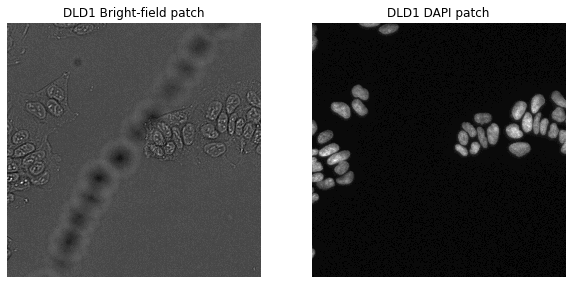

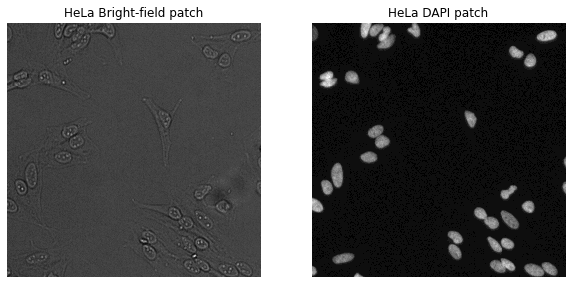

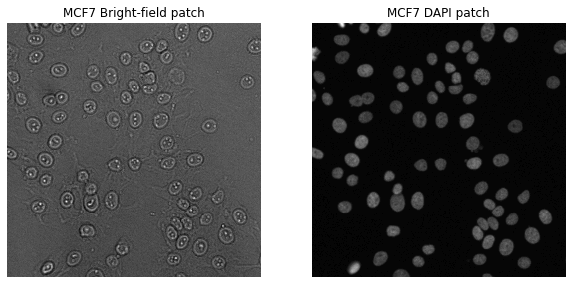

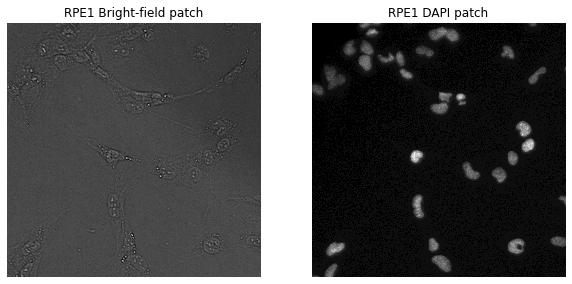

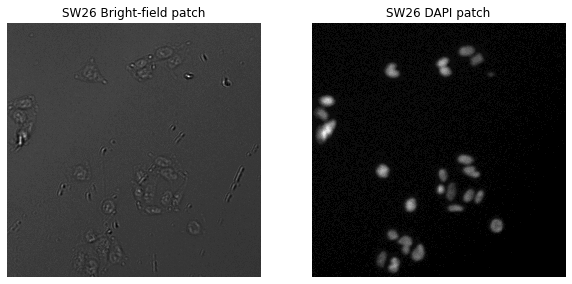

In [ ]:
#@markdown ##Run to display an example of each patch

base_name_patches_list = []
i = 0

for cell_line_name in sorted(cell_lines_list):
  tlpatches_cellline_folder_path = os.path.join(tlpatches_folder_path, cell_line_name)
  dapipatches_cellline_folder_path = os.path.join(dapipatches_folder_path, cell_line_name)

  for filename in os.listdir(tlpatches_cellline_folder_path):
    if filename.startswith(str(base_name_image_list[i])):

      tl_sample = io.imread(os.path.join(tlpatches_cellline_folder_path, filename), as_gray = True)
      dapi_sample = io.imread(os.path.join(dapipatches_cellline_folder_path, filename), as_gray = True)

      print(filename)

      f = plt.figure(figsize = (10,5))

      plt.subplot(1,2,1)
      plt.imshow(tl_sample, interpolation = 'nearest', cmap = 'gray')
      plt.title(f"{cell_line_name} Bright-field patch")
      plt.axis('off');

      plt.subplot(1,2,2)
      plt.imshow(dapi_sample, interpolation = 'nearest', cmap = 'gray')
      plt.title(f'{cell_line_name} DAPI patch')
      plt.axis('off');

      base_name_patch = filename.replace(".tif", "")
      base_name_patches_list.append(base_name_patch)
      figure_name = (f"Patch{cell_line_name}_{base_name_patch}")

      plt.savefig(os.path.join(generalfigures_folder_path, figure_name + ".png"),
                  dpi = 300, format = "png", bbox_inches = None)
      break

    else:
      pass

  i += 1

# **5. Segmentation Block - Cellpose**
---









In [ ]:
#@markdown ## Run to perform image segmentation.

#@markdown ### Please, specify if you want to perform segmentation with the default parameters.

Use_default_segmentation_parameters = True #@param {type:"boolean"}

#@markdown ### Otherwise, specifiy customized segmentation parameters:

Object_diameter = 24.5 #@param {type:"slider", min:7, max:30, step:1}

Flow_threshold = 0.4 #@param {type:"slider", min:0.1, max:1.1, step:0.1}

Cell_probability_threshold = 0 #@param {type:"slider", min:-6, max:6, step:1}

#@markdown ### Please, specify if you want to save the Cellpose's results as images.

save_cellpose = False #@param {type:"boolean"}

Channel_to_segment = [0,0]
if Use_default_segmentation_parameters:
  print("Default segmentation parameters enabled")
  Object_diameter = 24.5
  Flow_threshold = 0.4
  Cell_probability_threshold = 0

model = models.Cellpose(gpu = True, 
                        model_type = "nuclei",
                        net_avg = True,
                        device = None,
                        torch = False
)

for cell_line_name in cell_lines_list:
  dapipatches_cellline_folder_path = os.path.join(dapipatches_folder_path, cell_line_name)
  cellposefigures_cellline_folder_path = os.path.join(cellposefigures_folder_path, cell_line_name)

  for filename in sorted(os.listdir(dapipatches_cellline_folder_path)):

    print(f"Cellpose is computing labels from {filename} located in {cell_line_name}")

    image = io.imread(os.path.join(dapipatches_cellline_folder_path, filename))
    masks, flows, styles, diams = model.eval(image, 
                                            batch_size = 8,
                                            channels = Channel_to_segment,
                                            invert = False,
                                            normalize = False,
                                            diameter = Object_diameter,
                                            net_avg = True,
                                            augment = False,
                                            tile = True,
                                            resample = False,
                                            interp = True,
                                            flow_threshold = Flow_threshold,
                                            cellprob_threshold = Cell_probability_threshold
    )
    
    if save_cellpose:
      basename_filename = os.path.splitext(filename)[0]
      flowi = flows[0]
      fig = plt.figure(figsize=(12,5))
      plot.show_segmentation(fig, image, masks, flowi, channels=[0,0])
      plt.tight_layout()
      plt.savefig(os.path.join(cellposefigures_cellline_folder_path, str(basename_filename) + ".png"), 
                  dpi = 100, format = "png", bbox_inches = None)

    os.chdir(os.path.join(cellposelabelpatches_folder_path, cell_line_name))
    imsave(str(filename), masks, compress = ZIP_DEFLATED)


Default segmentation parameters enabled
** TORCH CUDA version installed and working. **
>>>> using GPU
Cellpose is computing labels from A5--W00005--P00001--PATCH1.tif located in DLD1
processing 1 image(s)
time spent: running network 0.62s; flow+mask computation 0.35
estimated masks for 1 image(s) in 0.98 sec
>>>> TOTAL TIME 0.98 sec
Cellpose is computing labels from A5--W00005--P00001--PATCH10.tif located in DLD1
processing 1 image(s)
time spent: running network 0.56s; flow+mask computation 0.29
estimated masks for 1 image(s) in 0.86 sec
>>>> TOTAL TIME 0.86 sec
Cellpose is computing labels from A5--W00005--P00001--PATCH11.tif located in DLD1
processing 1 image(s)
time spent: running network 0.56s; flow+mask computation 0.25
estimated masks for 1 image(s) in 0.82 sec
>>>> TOTAL TIME 0.82 sec
Cellpose is computing labels from A5--W00005--P00001--PATCH12.tif located in DLD1
processing 1 image(s)
time spent: running network 0.56s; flow+mask computation 0.38
estimated masks for 1 image(s)

ValueError: ignored

# **6. Localization Block**

---



In [ ]:
def measure_regionprops(labelpatch_folder_path, filename):
  '''
  This function computes image properties from a labelled image regions
  The information extracted will be used to crop each cell as snippet and to measure the mean intensity on the fluorescence channels

  INPUT:
  labelatch_folder_path: folder path of the label patches
  filename: unique name of the patch

  OUTPUT:
  regionprops_df: two-dimensional, size-mutable, potentially heterogeneous tabular data
  '''
  # Read label patches
  label = io.imread(os.path.join(labelpatch_folder_path, filename))

  # Compute image properties and return them as a pandas-compatible table
  regionprops_dict = measure.regionprops_table(label, 
                                               properties = ["label", 
                                                             "centroid", 
                                                             "area", 
                                                             "equivalent_diameter"]
  )

  # Convert the image properties table to a dataframe
  regionprops_df = pd.DataFrame()
  regionprops_df = pd.DataFrame(regionprops_dict)

  # Rename a few columns to be aligned to the structure (axis) of the data
  regionprops_df.rename(columns={"label": "cell_label",
                                 "centroid-0": "cx", 
                                 "centroid-1": "cy", 
                                 "equivalent_diameter": "diameter"}, 
                        inplace = True
  )

  # Remove rows in which nuclei's areas are under an specific value
  regionprops_df = regionprops_df[regionprops_df["area"] > 250]

  # Calculate bounding box (bbox) coordinates and store them directly into the dataframe
  regionprops_df["xmin"] = regionprops_df["cx"] - regionprops_df["diameter"]
  regionprops_df["xmax"] = regionprops_df["cx"] + regionprops_df["diameter"]
  regionprops_df["ymin"] = regionprops_df["cy"] - regionprops_df["diameter"]
  regionprops_df["ymax"] = regionprops_df["cy"] + regionprops_df["diameter"]

  # Remove rows in which bboxes' dimenions are out of patch's original dimensions
  regionprops_df = regionprops_df[(regionprops_df["xmin"] >= 0) &  
                                  (regionprops_df["xmax"] <= label.shape[1]) & 
                                  (regionprops_df["ymin"] >= 0) & 
                                  (regionprops_df["ymax"] <= label.shape[0])
  ]

  # Reset indexes of the dataframe and drop the previous index column
  regionprops_df.reset_index(inplace = True)
  regionprops_df.drop(labels = ["index"], axis = 1, inplace = True)

  # Add the name of the snippet in the dataframe as id value
  for idx in regionprops_df.index: 
    regionprops_df.loc[[idx], ["snippet_id"]] = (filename[:-4] + "--SNIPPET" + str(regionprops_df["cell_label"][idx]) + ".png")

  return regionprops_df

def save_regionpropsdataframe(save_regionprops_folder_path, regionprops_df, filename):
  '''
  This function saves the dataframe of the patch being analyzed as .csv

  INPUT:
  save_folder_path: folder path in which dataframe will be saved
  regionprops_df: two-dimensional, size-mutable, potentially heterogeneous tabular data of the mask properties
  filename: unique name of the patch
  '''
  # Get the basename of the file
  basename = filename.rstrip(".tif")

  # Get the complete path (folder path and filename) where the dataframe will be saved
  complete_save_path = os.path.join(save_regionprops_folder_path, 
                                    (basename + ".csv")
  )

  # Save the dataframe as .xlsx 
  regionprops_df.to_csv(complete_save_path, index = False)

def crop_tlsnippet(tlpatches_folder_path, regionprops_df, save_tlsnippet_folder_path, filename):
  '''
  This function saves all the snippets from the transmitted-light patch according to the bounding boxes dimenions

  INPUT:
  tlpatches_folder_path: folder path of the transmitted-light patches
  regionprops_df: two-dimensional, size-mutable, potentially heterogeneous tabular data of the mask properties
  save_tlsnippet_folder_path: folder path in which transmitted-light snippets will be saved
  filename: unique name of the patch
  '''
  # Read patch as PIL images
  tl_image = Image.open(os.path.join(tlpatches_folder_path, filename))

  for idx in regionprops_df.index:
    # Get the complete path (folder path and filename) where the snippet will be saved
    complete_save_path = os.path.join(save_tlsnippet_folder_path, 
                                      (str(regionprops_df["snippet_id"][idx]))
    )

    # Crop snippet from transmitted light patch 
    tl_snippet = tl_image.crop((regionprops_df["ymin"][idx], 
                                regionprops_df["xmin"][idx], 
                                regionprops_df["ymax"][idx], 
                                regionprops_df["xmax"][idx])
    )

    # Convert to uint8 numpy array
    tl_snippet = img_as_ubyte(np.array(tl_snippet))

    # Save the snippet into the folder
    io.imsave(complete_save_path, tl_snippet)

#@markdown ##Run to compute TL snippets and regionprops dataframe

print("Snippets being created...")

number_of_snippets = []

for cell_line_name in cell_lines_list:
  cellposelabelpatches_cellline_folder_path = os.path.join(cellposelabelpatches_folder_path, cell_line_name)
  regionpropsdf_cellline_folder_path = os.path.join(regionpropsdf_folder_path, cell_line_name)
  tlpatches_cellline_folder_path = os.path.join(tlpatches_folder_path, cell_line_name)
  tlsnippets_cellline_folder_path = os.path.join(tlsnippets_folder_path, cell_line_name)
  cellposefigures_cellline_folder_path = os.path.join(cellposefigures_folder_path, cell_line_name)
  dapipatches_cellline_folder_path = os.path.join(dapipatches_folder_path, cell_line_name)

  for filename in sorted(os.listdir(cellposelabelpatches_cellline_folder_path)):

    check_label = io.imread(os.path.join(cellposelabelpatches_cellline_folder_path, filename))
    if len(np.unique(check_label)) > 1:
      regionprops_df = measure_regionprops(cellposelabelpatches_cellline_folder_path, filename)
      save_regionpropsdataframe(regionpropsdf_cellline_folder_path, regionprops_df, filename)
      crop_tlsnippet(tlpatches_cellline_folder_path, regionprops_df, tlsnippets_cellline_folder_path, filename)

    else:
      os.remove(os.path.join(tlpatches_cellline_folder_path, filename))
      os.remove(os.path.join(dapipatches_cellline_folder_path, filename))
      os.remove(os.path.join(cellposelabelpatches_cellline_folder_path, filename))
      figure_filename = filename.replace(".tif", ".png")
      if save_cellpose:
        os.remove(os.path.join(cellposefigures_cellline_folder_path, figure_filename))

  print(f"{cell_line_name} snippets just created")
  number_of_files = len([filename for filename in os.listdir(tlsnippets_cellline_folder_path) if os.path.isfile(os.path.join(tlsnippets_cellline_folder_path, filename))])
  number_of_snippets.append(len([filename for filename in os.listdir(tlsnippets_cellline_folder_path) if os.path.isfile(os.path.join(tlsnippets_cellline_folder_path, filename))]))
  print(f"{number_of_files} {cell_line_name} snippets")
  print("\n") 
  print(f"TOTAL: {sum(number_of_snippets)} snippets of {len(cell_lines_list)} cell lines.")


In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to display an example of each snippet

##############################
######### FUNCTIONS ##########
##############################


i = 0

for cell_line_name in sorted(cell_lines_list):
  tlsnippets_cellline_folder_path = os.path.join(tlsnippets_folder_path, cell_line_name)

  for filename in os.listdir(tlsnippets_cellline_folder_path):

    tl_sample = io.imread(os.path.join(tlsnippets_cellline_folder_path, filename), as_gray = True)

    print(filename)

    f = plt.figure(figsize = (5,5))

    plt.subplot(1,1,1)
    plt.imshow(tl_sample, interpolation = 'nearest', cmap = 'gray')
    plt.title(f'{cell_line_name} Bright-field snippet ')
    plt.axis('off');

    base_name_snippet = filename.replace(".png", "")
    figure_name = (f"Snippet{cell_line_name}_{base_name_patch}")

    plt.savefig(os.path.join(generalfigures_folder_path, figure_name + ".png"),
                dpi = 300, format = "png", bbox_inches = None)
    
    break

  i += 1

# **7. Classification Block**

---



In [ ]:
#@markdown ##Are you debugging?

DEBUG = True #@param {type:"boolean"}

## **7.1. Define main parameters**

---



In [ ]:
#@markdown ##Please specify the path to where the data is located in your Google Drive.

drivemodel_folder_path = '/content/gdrive/MyDrive/_WhoIsWhoModels/TL8bits/Monoculture_10x_LowC/DatasetA' #@param {type:"string"}
drivemodel_folder_path = drivemodel_folder_path + "/"

#@markdown ### Please select whether you want to use the default classification paramters.

Use_Default_Classification_Parameters = True #@param {type:"boolean"}

#@markdown ### If not, please input:

#@markdown ##### Network Architecture
initial_epochs = 10 #@param {type:"number"}
fine_tune_epochs = 10 #@param {type:"number"}
batch_size =  2 #@param [2, 4, 8, 16, 32, 64, 128, 256] {type:"raw"}
# try 2, 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
percentage_validation = 20  #@param {type:"slider", min:1, max:100, step:1}

#@markdown ##### Image size
img_height = 299 #@param {type:"number"}
img_width = 299 #@param {type:"number"}

#@markdown ##### Callbacks
EarlyStopping_patience = 3 #@param {type:"slider", min:1, max:10, step:1}
monitor_callback = "val_loss" #@param ["acc", "loss", "val_acc", "val_loss"]

if Use_Default_Classification_Parameters: 
  print("Default classification parameters enabled")
  initial_epochs = 10 
  fine_tune_epochs = 10
  batch_size = 4
  percentage_validation = 10
  img_height = 299
  img_width = 299
  patience = 3


img_size = (img_height, img_width)
total_epochs =  initial_epochs + fine_tune_epochs

class_weights = {}
for idx, item in enumerate(sorted(cell_lines_list)):
  class_weights[idx] = max(number_of_snippets) / number_of_snippets[idx] 

## **7.2. Creation of train and validation dataset**

---



In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to create train and validation datasets.

##############################
######### FUNCTIONS ##########
##############################

print("TRAIN DATASET") 
train_dataset = image_dataset_from_directory(
    directory = tlsnippets_folder_path,
    labels = "inferred",
    label_mode = "int",
    class_names = None, 
    color_mode = "rgb", 
    batch_size = batch_size, 
    image_size = (img_height, img_width),
    shuffle = True, 
    seed = 32, 
    validation_split = (percentage_validation / 100), 
    subset = "training",
    follow_links = False
)
print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset)}")

print("\n") 
print("VALIDATION DATASET") 
validation_dataset = image_dataset_from_directory(
    directory = tlsnippets_folder_path,
    labels = "inferred",
    label_mode = "int",
    class_names = None, 
    color_mode = "rgb", 
    batch_size = batch_size, 
    image_size = (img_height, img_width),
    shuffle = True, 
    seed = 32, 
    validation_split = (percentage_validation / 100), 
    subset = "validation", 
    follow_links = False
)

print(f"Number of validation batches: {cardinality(validation_dataset)}.")

if DEBUG: 
  print("\n") 
  class_names = train_dataset.class_names
  print(f"Name of the classes found: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
if DEBUG: 
  print("\n") 
  print("Enabled buffered prefetching so you can yield data from disk without having I/O become blocking.")

## **7.3. Set the data augmentation**

---



In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to configure the data augmentation layer and display a snippet.

##############################
######### FUNCTIONS ##########
##############################

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip(mode = "horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2, fill_mode = 'reflect', interpolation = 'bilinear'),
  preprocessing.RandomZoom(0.2, fill_mode = 'reflect', interpolation = 'bilinear')
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

    plt.savefig(os.path.join(model_folder_path, "DataAugmentationExample.png"), 
                dpi = 300, format = "png", bbox_inches = None)

## **7.4. Build the model**

---



In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to build the base model and stack the classification layers on top.

##############################
######### FUNCTIONS ##########
##############################

# Preprocessing layer according to the model chosen
preprocess_input = xception.preprocess_input

# LOAD IN THE PRETRAINED BASE MODEL (AND PRETRAINED WEIGHTS)
print("Loading in the pretrained base model (and pretrained weights)...")
print("\n")
# Creation of the base model
img_shape = img_size + (3,)
base_model = xception.Xception(
    include_top = False, 
    weights = 'imagenet',  
    input_shape = img_shape
)
if DEBUG:
  image_batch, label_batch = next(iter(train_dataset))
  feature_batch = base_model(image_batch)
  print("The base model act as a feature extractor.")
  print(f"Snippets are reshaped from 299x299x3 into a {feature_batch.shape[1:]} block of features.")
  print("\n") 

# Freeze the convolutional base
base_model.trainable = False
if DEBUG:
  print("Freezed the convolutional base.")
  print("It will prevent the weights of the base model from being updated during training.")
  base_model.summary()
  print("\n") 

# STACK THE CLASSIFICATION LAYERS ON TOP
print("Stacking the classification layers on top...")
print("\n")
# Addition of a classification head
global_average_layer = GlobalAveragePooling2D()
if DEBUG:
  feature_batch_average = global_average_layer(feature_batch)
  print("Applied a GlobalAveragePooling2D() layer.")
  print(f"To generate predictions from the block of features, average over the spatial {feature_batch.shape[1:3]} spatial locations.")
  print(f"In order to convert the features to a single {feature_batch_average.shape[1]}-element vector per image.")
  print("\n") 

num_classes = len(class_names)
prediction_layer = Dense(num_classes)
if DEBUG:
  prediction_batch = prediction_layer(feature_batch_average)
  print("Applied a Dense() layer.")
  print("Convert features into predictions according to the number of classes.")
  print(f"There is no need to apply activation function because prediction will be treated as a logit of {prediction_batch.shape[1]} outputs.")
  print("\n") 
  
# Build the model
inputs = keras.Input(shape = img_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

print("The model has been composed correctly!")

## **7.5. Train the model**

### **7.5.1. Train the classification layers**

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to compile the model

##############################
######### FUNCTIONS ##########
##############################

base_learning_rate = 0.001

model.compile(
    optimizer = Nadam(learning_rate = base_learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, name='Nadam'),
    loss = SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ["accuracy"]
)

if DEBUG:
  model.summary()
  print("\n") 
  print("Base model being used as a fixed feature structure.")
  print("Just the classification head layers being trained and updated.")

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to train the top classification layers of the model.

##############################
######### FUNCTIONS ##########
##############################

checkpoint_cb = ModelCheckpoint(
    os.path.join(drivemodel_folder_path, "weights_best.hdf5"), 
    monitor = monitor_callback, 
    verbose = 1, 
    save_best_only = True,
    mode = "auto",
    save_weights_only = False,
    save_freq = 'epoch',
)

csvlogger_cb = CSVLogger(
    os.path.join(model_folder_path, "model_log.csv"),
    separator = ',', 
    append = False
)

if DEBUG:
  print("Set ModelCheckpoint() as a callback for the model.")
  print(f"ModelCheckpoint() is monitoring {monitor_callback} during training of the model.")
  print("\n")
  print("Set CSVLogger() as a callback for the model.") 
  print("\n")

history = model.fit(
    train_dataset,
    epochs = initial_epochs,
    callbacks = [checkpoint_cb, csvlogger_cb],
    validation_data = validation_dataset,
    class_weight = class_weights,
    verbose = 1
)

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Display and save the learning curves of the training of the top classification layers of the model.

##############################
######### FUNCTIONS ##########
##############################

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

initial_epoch = []
for e in history.epoch:
  initial_epoch.append(e+1)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(initial_epoch, acc, label='Training Accuracy')
plt.plot(initial_epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.autoscale(enable=True, axis='both')
plt.xticks(ticks = initial_epoch)

plt.subplot(2, 1, 2)
plt.plot(initial_epoch, loss, label='Training Loss')
plt.plot(initial_epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Sparse Categorical Crossentropy')
plt.xlabel('epoch')
plt.autoscale(enable=True, axis='both')
plt.xticks(ticks = initial_epoch)

plt.savefig(os.path.join(model_folder_path, "LearningCurvesTopClassificationLayers.png"),
            dpi = 300, format = "png", bbox_inches = None)

### **7.5.2. Round of fine-tuning**

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ## Run to compile the model

##############################
######### FUNCTIONS ##########
##############################

# Unfreeze the convolutional base and set the bottom layers to be un-trainable
base_model.trainable = True
fine_tune_at = round(len(base_model.layers) * (2/3))
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
if DEBUG:
  print(f"There are {len(base_model.layers)} layers on the base model")
  print(f"Fine-tuning from {fine_tune_at} layer onwards.")
  print("\n") 

model.compile(
    optimizer = Nadam(learning_rate = base_learning_rate / 10, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, name = 'Nadam'),
    loss = SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)
if DEBUG:
  print("Model compiled!")
  model.summary()


In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to train the entire model.

##############################
######### FUNCTIONS ##########
##############################

# Set EarlyStopping callback
earlystopping_cb = EarlyStopping(
    monitor = monitor_callback, 
    min_delta = 0, 
    patience = EarlyStopping_patience, 
    verbose = 1,
    mode = 'auto', 
)

csvlogger_cb.append = True

if DEBUG:
  print("Set ModelCheckpoint() as a callback for the model.")
  print(f"ModelCheckpoint() is monitoring {monitor_callback} during training of the model.")
  print("\n")
if DEBUG:
  print("Set EarlyStopping() as a callback for the model.")
  print(f"EarlyStopping()'s patience = {patience}.")
  print("\n") 
 
history_fine = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = history.epoch[-1]+1,
    callbacks = [checkpoint_cb, earlystopping_cb, csvlogger_cb],
    validation_data = validation_dataset,
    class_weight = class_weights,
    verbose = 1
)

model.save(os.path.join(drivemodel_folder_path, 'weights_last.hdf5'))

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Display and save the learning curves of the entire training

##############################
######### FUNCTIONS ##########
##############################

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

epochs = []
for e in history_fine.epoch:
  epochs.append(e+1)

fine_tune_epochs = initial_epoch + epochs

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(fine_tune_epochs, acc, label='Training Accuracy')
plt.plot(fine_tune_epochs, val_acc, label='Validation Accuracy')
plt.plot([initial_epoch[-1], initial_epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.autoscale(enable=True, axis='both')
plt.xticks(ticks = fine_tune_epochs)

plt.subplot(2, 1, 2)
plt.plot(fine_tune_epochs, loss, label='Training Loss')
plt.plot(fine_tune_epochs, val_loss, label='Validation Loss')
plt.plot([initial_epoch[-1], initial_epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Sparse Categorical Crossentropy')
plt.xlabel('epoch')
plt.autoscale(enable=True, axis='both')
plt.xticks(ticks = fine_tune_epochs)

plt.savefig(os.path.join(model_folder_path, "LearningCurvesFineTuning.png"),
            dpi = 300, format = "png", bbox_inches = None)

# **8. Download files**

In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Please select the folders to be downloaded

figures_folder = True #@param {type:"boolean"}
model_folder = True #@param {type:"boolean"}
regionprops_folder = True #@param {type:"boolean"}
patches_folder = False #@param {type:"boolean"}
snippets_folder = False #@param {type:"boolean"}

if figures_folder:
  !zip -r /content/WhoIsWho/Figures.zip /content/WhoIsWho/Figures

if model_folder:
  !zip -r /content/WhoIsWho/Model.zip /content/WhoIsWho/Model

if regionprops_folder:
  !zip -r /content/WhoIsWho/Regionpropsdf.zip /content/WhoIsWho/Patches/Regionpropsdf

if patches_folder:
  !zip -r /content/WhoIsWho/Patches.zip /content/WhoIsWho/Patches

if snippets_folder:
  !zip -r /content/WhoIsWho/Snippets.zip /content/WhoIsWho/Snippets



In [ ]:
##############################
########## MARKDOWN ##########
##############################

#@markdown ##Run to download as a zip the folders selected

if figures_folder:
  files.download("/content/WhoIsWho/Figures.zip")

if model_folder:
  files.download("/content/WhoIsWho/Model.zip")

if regionprops_folder:
  files.download("/content/WhoIsWho/Regionpropsdf.zip") 

if patches_folder:
  files.download("/content/WhoIsWho/Patches.zip")

if snippets_folder:
  files.download("/content/WhoIsWho/Snippets.zip")